In [1]:
import numpy as np
import pandas as pd
import math

from croissance import process_curve
from croissance.estimation import fit_exponential
from croissance.estimation.util import normalize_time_unit
from croissance.figures import PDFWriter

import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import curve_fit

import seaborn as sns

# Function to analyze growth curve

In [123]:
# "infile" is the relative/full path of the growth curve experimental data of 96-well plates
# check 181109_glycerol_clinical.csv for input data format

# min_od: regions with od smaller than min_od will be removed

# blank: row or column used as blank control wells. Allowed values: 'A'-'H' for rows and '1'-'12' for columns

# verbose: whether to print information in process

def growth_curve_analysis(infile, min_od, blank, verbose):
    # read data
    if infile.split('.')[-1] == 'xlsx':
        df = pd.read_excel(infile, index_col=1).squeeze()
    elif infile.split('.')[-1] == 'csv':
        df = pd.read_csv(infile, index_col=1).squeeze()
    else:
        print('file format not recognized. support xlsx and csv only.')
        return
    
    # remove columns for temperature and cycle
    df=df.drop(columns=[df.columns[0],df.columns[1]])
    
    # convert time unit to hour
    df.index = df.index/3600
    df.index.names = ['Time (h)']
    
    #print(df.head())

    # subtract baseline data (controls)
    if blank.isalpha():
        # the blank is a row
        for index, col in enumerate(df.columns):
            # the variable "blank" is a letter, we need digits
            digits = ''.join(i for i in col if i.isdigit())
            #print(col, blank+digits)
            blank_index = df.columns.values.tolist().index(blank + digits)
            df.iloc[:,index] = df.iloc[:,index] - df.iloc[:,blank_index]
    
    if blank.isdigit():
        # the blank is a column
        for index, col in  enumerate(df.columns):
            # the variable "blank" is digital, we need a letter
            letter = ''.join(i for i in col if i.isalpha())
            #print(col, letter+blank)
            blank_index = df.columns.values.tolist().index(letter + blank)
            df.iloc[:,index] = df.iloc[:,index] - df.iloc[:,blank_index]
            
    # to plot
    fig, axes = plt.subplots(nrows=8, ncols=12, figsize=(16, 10))
  
    saved_data = []
    for index, col in enumerate(df.columns): 
        row_index = int(index % 8)
        col_index = int(np.floor(index/8))   
        
        try:
            # cutoff OD
            curve = df.loc[df[col] >= min_od, col] # growth curve
            if curve.empty: # curve is empty
                mydict = {}
                mydict.update({'maxGR'   : 0,
                               'minGR'   : 0,
                               '1stGR'   : 0,
                               'LagT'    : max(df.index),
                               'InitOD'  : 0,
                               'MaxOD'   : 0,
                               'FinalOD' : 0})
                print(col, ': no growth phase is found.')
                saved_data.append(mydict)
                continue
                
            # extract growth parameters using croissance
            results = process_curve(curve,constrain_n0=True, n0=0.)
        except:
            # no cutoff
            curve = df[col] # growth curve
            if curve.empty: # curve is empty
                mydict = {}
                mydict.update({'maxGR'   : 0,
                               'minGR'   : 0,
                               '1stGR'   : 0,
                               'LagT'    : max(df.index),
                               'InitOD'  : 0,
                               'MaxOD'   : 0,
                               'FinalOD' : 0})
                print(col, ': no growth phase is found.')
                saved_data.append(mydict)
                continue
                
            # extract growth parameters using croissance
            results = process_curve(curve,constrain_n0=True, n0=0.)
            
        # find the index of the first growth phase
        phase_start = []
        for phase in results.growth_phases:
            phase_start.append(phase.start)
        if phase_start:
            first_growth_phase_index = np.argmin(phase_start)
            phase_order_in_time = np.argsort(phase_start)
    
        # get growth rate and lag time for each growth phase
        # for the first phase, we fit an exponential model with a free-varying constant offset
        # for all other phases (which may or may not grow exponential), we approximat it using exponential model
        growth_rate = []
        growth_lag  = np.max(df.index.values)
        rank = []
        colors = ['r', 'b', 'g', 'c', 'y'] # decresing hues
        for phase_index, phase in enumerate(results.growth_phases): # growth phases have been ranked
            phase_series = results.series[phase.start:phase.end]
        
            def exp_growth_w_offset(x, y0, y1, mu):
                return y0 + y1 * np.exp(mu * x)
            
            def exp_growth_wo_offset(x, y1, mu):
                return y1 * np.exp(mu * x)
            
            w_offset = True
            if phase_index == first_growth_phase_index:
                try:
                    # fit with w/ offset model
                    init_vals = [phase_series.values[0], 
                                 1/ np.exp(phase.intercept * phase.slope),
                                 phase.slope]  # for [y0, y1, mu]
                    best_vals, covar = curve_fit(exp_growth_w_offset, phase_series.index, phase_series.values, p0=init_vals, 
                                                 bounds = ([0,0,0], [math.inf,math.inf,math.inf]), maxfev=10000)
                    
                    growth_lag = np.log(best_vals[0]/best_vals[1])/best_vals[2]
                    if (growth_lag <0):
                        #print('%s: lag time is negative using w/ offset model. Using w/o offset model instead.' % (col))
                        raise ValueError
                    else:
                        growth_rate.append(best_vals[2])  
                except:
                    # fit with w/o offset model
                    w_offset = False
                    init_vals = [1/ np.exp(phase.intercept * phase.slope),
                                 phase.slope]  # for [y1, mu]
                    best_vals, covar = curve_fit(exp_growth_wo_offset, phase_series.index, phase_series.values, p0=init_vals, 
                                                 bounds = ([0,0], [math.inf,math.inf]), maxfev=10000)
                    
                    growth_lag = -np.log(best_vals[0])/best_vals[1]
                    if (growth_lag <0):
                        print('%s: lag time is also negative using w/o offset model. Terminate.' % (col))
                        raise ValueError
                    else:
                        growth_rate.append(best_vals[1])
            else:
                w_offset = False
                init_vals = [1/ np.exp(phase.intercept * phase.slope),
                             phase.slope]  # for [y1, mu]
                best_vals, covar = curve_fit(exp_growth_wo_offset, phase_series.index, phase_series.values, p0=init_vals, 
                                             bounds = ([0,0], [math.inf,math.inf]), maxfev=10000)
        
                growth_rate.append(best_vals[1])
            
            if (growth_rate[-1]<0):
                print('%s: growth rate is negative. Terminate.' % (col))
                raise ValueError
            
            rank.append(phase.rank)
            
            #=======
            # plot
            #=======
            color = colors[phase_index % len(colors)]
            # plot local growth phases identified by croissance
            axes[row_index, col_index].plot(phase_series.index,
                                            phase_series.values,
                                            marker=None,
                                            linewidth=5,
                                            color=color,
                                            solid_capstyle='butt',
                                            alpha=0.5)
            # plot model fitting
            if (phase_index == first_growth_phase_index) and w_offset:
                axes[row_index, col_index].plot(results.series.index,
                                                exp_growth_w_offset(results.series.index, best_vals[0], best_vals[1], best_vals[2]), 
                                                color=color,
                                                linewidth=1,
                                                linestyle='solid')
            else:
                axes[row_index, col_index].plot(results.series.index,
                                                exp_growth_wo_offset(results.series.index, best_vals[0], best_vals[1]), 
                                                color=color,
                                                linewidth=1,
                                                linestyle='solid')
                
        if verbose:
            if len(results.growth_phases)==0:
                print(col, ': no growth phase is found.')
            else:
                print('%s : %d growth phases found, rank=(' % (col, len(results.growth_phases)), end='')
                for index_phase in range(len(results.growth_phases)):
                    if index_phase == len(results.growth_phases)-1:
                        print('%3.2f), growth rate=(' % rank[phase_order_in_time[index_phase]], end='')
                    else:
                        print('%3.2f,' % rank[phase_order_in_time[index_phase]], end='')
                        
                for index_phase in range(len(results.growth_phases)):
                    if index_phase == len(results.growth_phases)-1:
                        print('%1.2f), ' % growth_rate[phase_order_in_time[index_phase]], end='')
                    else:
                        print('%1.2f,' % growth_rate[phase_order_in_time[index_phase]], end='')
                        
                print('growth lag = %2.2f' % (growth_lag))

        mydict = {}      
        if len(results.growth_phases)==0:
            mydict.update({'minGR'   : 0,
                           'maxGR'   : 0,
                           '1stGR'   : 0,
                           'LagT'    : np.max(df.index.values),
                           'InitOD'  : curve.values[0],
                           'MaxOD'   : np.max(curve.values),
                           'FinalOD' : curve.values[-1]})
        else:
            mydict.update({'minGR'   : np.min(growth_rate),
                           'maxGR'   : np.max(growth_rate),
                           '1stGR'   : growth_rate[first_growth_phase_index],
                           'LagT'    : growth_lag,
                           'InitOD'  : curve.values[0],
                           'MaxOD'   : np.max(curve.values),
                           'FinalOD' : curve.values[-1]})
        saved_data.append(mydict)
        
        #======
        # plot
        #======                  
        # plot original data
        axes[row_index, col_index].plot(results.series.index,
                                        results.series.values,
                                        color='black',
                                        marker='.',
                                        markersize=1,
                                        linestyle='None')
        # plot outliers
        axes[row_index, col_index].plot(results.outliers.index,
                                        results.outliers.values,
                                        color='red',
                                        marker='.',
                                        markersize=1,
                                        linestyle='None')
        
        axes[row_index, col_index].set_xlim([0,np.max(df.index.values)])
        if curve.max()>0:
            if curve.min()>0:
                axes[row_index, col_index].set_ylim([curve.min()/2, curve.max()*2])
            else:
                axes[row_index, col_index].set_ylim([0.005, curve.max()*2])
            axes[row_index, col_index].set_yscale('log')
        axes[row_index, col_index].set_xticklabels([])
        axes[row_index, col_index].set_yticklabels([]) 
        axes[row_index, col_index].minorticks_off()
        
    # output
    Op = pd.DataFrame(saved_data)
    Op = Op[['minGR','maxGR','1stGR','LagT','InitOD','MaxOD','FinalOD']]
    Op.index = df.columns
    
    plt.show()
    plt.tight_layout()
    
    return Op

# Run example 1: Pseudomonas aeruginosa in glycerol minimal

A1 : no growth phase is found.
B1 : no growth phase is found.
C1 : no growth phase is found.
D1 : no growth phase is found.
E1 : no growth phase is found.
F1 : no growth phase is found.
G1 : no growth phase is found.
H1 : no growth phase is found.
A2 : 2 growth phases found, rank=(100.00,43.25), growth rate=(0.30,0.02), growth lag = 17.06
B2 : 2 growth phases found, rank=(73.21,62.59), growth rate=(0.31,0.03), growth lag = 17.17
C2 : 2 growth phases found, rank=(53.68,61.52), growth rate=(0.30,0.03), growth lag = 17.21
D2 : 2 growth phases found, rank=(47.72,64.32), growth rate=(0.32,0.03), growth lag = 16.89
E2 : 2 growth phases found, rank=(55.54,60.93), growth rate=(0.28,0.03), growth lag = 17.55
F2 : 2 growth phases found, rank=(56.29,59.79), growth rate=(0.30,0.03), growth lag = 17.16
G2 : 2 growth phases found, rank=(55.21,60.92), growth rate=(0.28,0.03), growth lag = 16.66
H2 : 2 growth phases found, rank=(100.00,57.93), growth rate=(0.26,0.01), growth lag = 17.57
A3 : 1 growth 

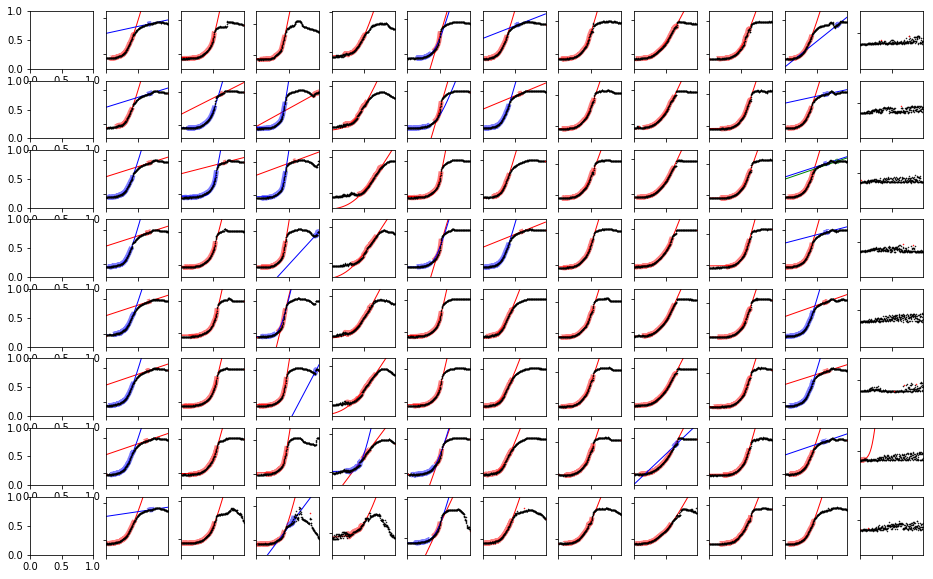

<Figure size 432x288 with 0 Axes>

In [102]:
output1 = growth_curve_analysis(infile='181109_glycerol_clinical.csv', min_od=0.01, blank='1', verbose=True)

In [66]:
output1.head()

,minGR,maxGR,1stGR,LagT,InitOD,MaxOD,FinalOD
A1,0.0,0.0,0.0,48.603361,0.0,0.0,0.0
B1,0.0,0.0,0.0,48.603361,0.0,0.0,0.0
C1,0.0,0.0,0.0,48.603361,0.0,0.0,0.0
D1,0.0,0.0,0.0,48.603361,0.0,0.0,0.0
E1,0.0,0.0,0.0,48.603361,0.0,0.0,0.0


## Visualize growth rate

0.00 <= min growth rate (1/h) <= 0.58
0.00 <= max growth rate (1/h) <= 0.62
0.00 <= 1st growth rate (1/h) <= 0.62


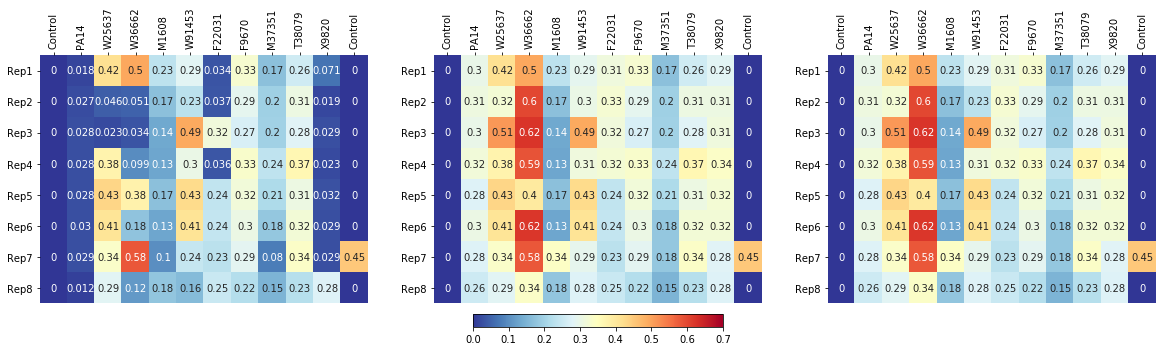

In [111]:
print('%2.2f <= min growth rate (1/h) <= %2.2f' %(np.min(output1['minGR'].values), np.max(output1['minGR'].values)))
print('%2.2f <= max growth rate (1/h) <= %2.2f' %(np.min(output1['maxGR'].values), np.max(output1['maxGR'].values)))
print('%2.2f <= 1st growth rate (1/h) <= %2.2f' %(np.min(output1['1stGR'].values), np.max(output1['1stGR'].values)))

fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,1,1]},figsize=(20,5))

# min growth rate
to_plot1 = pd.DataFrame(output1['minGR'].values.reshape(8,12,order='F'))
g1 = sns.heatmap(to_plot1, robust=True, annot=True, cmap='RdYlBu_r', vmin=0, vmax=0.7, ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')

# max growth rate
to_plot2 = pd.DataFrame(output1['maxGR'].values.reshape(8,12,order='F'))
g2 = sns.heatmap(to_plot2, robust=True, annot=True, cmap='RdYlBu_r', vmin=0, vmax=0.7, ax=ax2, cbar=False)
g2.set_ylabel('')
g2.set_xlabel('')

# 1st growth rate
to_plot3 = pd.DataFrame(output1['1stGR'].values.reshape(8,12,order='F'))
g3 = sns.heatmap(to_plot3, robust=True, annot=True, cmap='RdYlBu_r', vmin=0, vmax=0.7, ax=ax3, cbar=False)
g3.set_ylabel('')
g3.set_xlabel('')

for ax in [g1,g2,g3]:
    ax.set_yticklabels(['Rep1','Rep2','Rep3','Rep4','Rep5','Rep6','Rep7','Rep8'], rotation=0)
    ax.set_xticklabels(['Control','PA14','W25637','W36662','M1608','W91453','F22031','F9670','M37351','T38079','X9820','Control'], rotation=90)
    ax.xaxis.tick_top()
    
mappable = g1.get_children()[0]
cbar=plt.colorbar(mappable, ax = [ax1,ax2,ax3],orientation = 'horizontal',fraction=0.046, pad=0.04)
cbar.set_ticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])

plt.show()

## Visualize lag time

10.51 <= lag time (h) <= 48.60


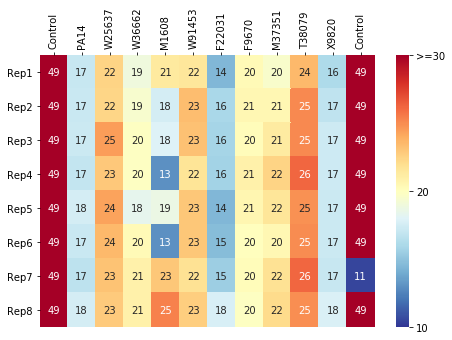

In [112]:
print('%2.2f <= lag time (h) <= %2.2f' %(np.min(output1['LagT'].values), np.max(output1['LagT'].values)))

fig,ax = plt.subplots(1,1,figsize=(7.5,5))
to_plot = pd.DataFrame(output1['LagT'].values.reshape(8,12,order='F'))
g = sns.heatmap(to_plot, robust=True, annot=True, cmap='RdYlBu_r', vmin=10, vmax=30, ax=ax, cbar=True)
ax.set_yticklabels(['Rep1','Rep2','Rep3','Rep4','Rep5','Rep6','Rep7','Rep8'], rotation=0)
ax.set_xticklabels(['Control','PA14','W25637','W36662','M1608','W91453','F22031','F9670','M37351','T38079','X9820','Control'], rotation=90)
ax.xaxis.tick_top()
cbar = ax.collections[0].colorbar
cbar.set_ticks([10,20,30])
cbar.set_ticklabels(['10', '20', '>=30'])

# Run example 2: PA14 and NalD mutant in glycerol + casamino acids

A1 : 1 growth phases found, rank=(100.00), growth rate=(0.01), growth lag = 108.03
B1 : 1 growth phases found, rank=(100.00), growth rate=(1.12), growth lag = 6.60
C1 : 2 growth phases found, rank=(93.40,33.66), growth rate=(1.04,0.02), growth lag = 1.92
D1 : 1 growth phases found, rank=(100.00), growth rate=(1.12), growth lag = 6.51
E1 : 1 growth phases found, rank=(100.00), growth rate=(1.43), growth lag = 0.81
F1 : 2 growth phases found, rank=(77.88,55.94), growth rate=(1.90,0.39), growth lag = 6.26
G1 : no growth phase is found.
H1 : no growth phase is found.
A2 : 1 growth phases found, rank=(100.00), growth rate=(1.11), growth lag = 6.60
B2 : 2 growth phases found, rank=(85.30,48.25), growth rate=(0.99,0.03), growth lag = 6.97
C2 : 2 growth phases found, rank=(86.45,35.86), growth rate=(1.01,0.03), growth lag = 6.95
D2 : 2 growth phases found, rank=(85.60,34.09), growth rate=(0.96,0.06), growth lag = 1.17
E2 : 1 growth phases found, rank=(100.00), growth rate=(1.39), growth lag = 

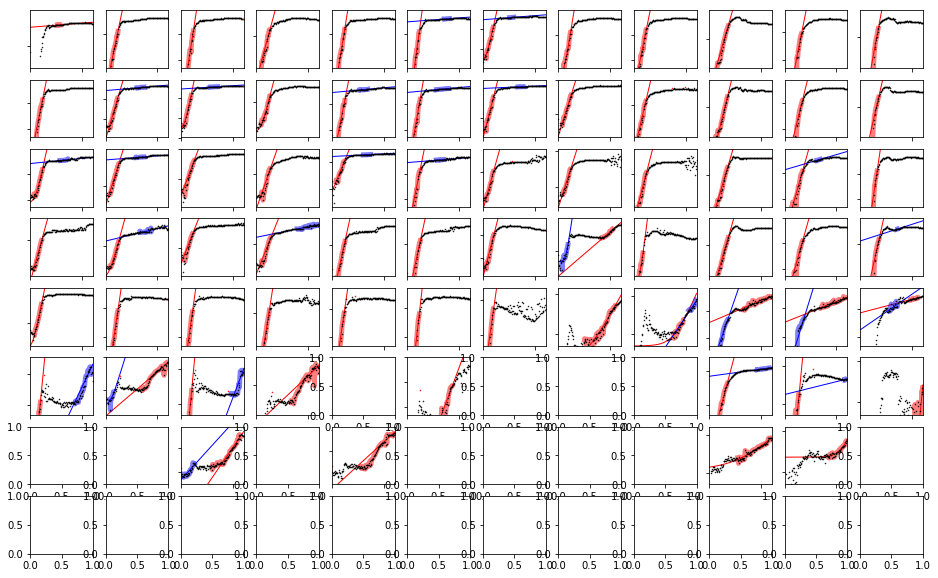

<Figure size 432x288 with 0 Axes>

In [130]:
# Cutoff at zero causes divided by zero error. Switch to no cutoff
output2 = growth_curve_analysis(infile='181219_aztMIC.xlsx', min_od=0.01, blank='H', verbose=True)

In [125]:
output2.head()

,minGR,maxGR,1stGR,LagT,InitOD,MaxOD,FinalOD
A1,0.011757,1.027735,1.027735,6.709342,0.0709,0.3690,0.3459
B1,1.115192,1.115192,1.115192,6.599353,-0.0023,0.3770,0.3530
C1,0.022628,1.036190,1.036190,1.919898,0.0121,0.4334,0.4192
D1,1.121194,1.121194,1.121194,6.513026,0.0031,0.6896,0.6815
E1,1.427053,1.427053,1.427053,0.809698,0.0043,0.2780,0.2117


## Visualize growth rate

0.00 <= min growth rate (1/h) <= 2.68
0.00 <= max growth rate (1/h) <= 3.29
0.00 <= 1st growth rate (1/h) <= 3.29


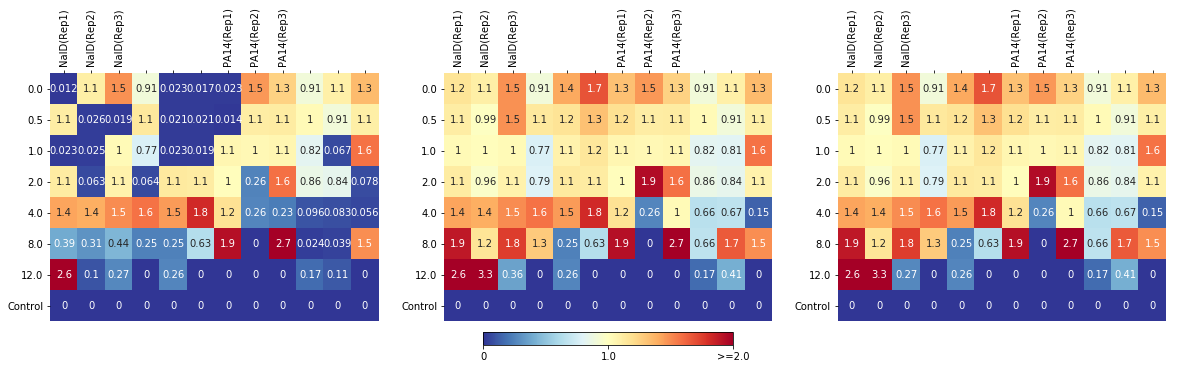

In [129]:
print('%2.2f <= min growth rate (1/h) <= %2.2f' %(np.min(output2['minGR'].values), np.max(output2['minGR'].values)))
print('%2.2f <= max growth rate (1/h) <= %2.2f' %(np.min(output2['maxGR'].values), np.max(output2['maxGR'].values)))
print('%2.2f <= 1st growth rate (1/h) <= %2.2f' %(np.min(output2['1stGR'].values), np.max(output2['1stGR'].values)))

fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,1,1]},figsize=(20,5))

# min growth rate
to_plot1 = pd.DataFrame(output2['minGR'].values.reshape(8,12,order='F'))
g1 = sns.heatmap(to_plot1, robust=True, annot=True, cmap='RdYlBu_r', vmin=0, vmax=2.0, ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')

# max growth rate
to_plot2 = pd.DataFrame(output2['maxGR'].values.reshape(8,12,order='F'))
g2 = sns.heatmap(to_plot2, robust=True, annot=True, cmap='RdYlBu_r', vmin=0, vmax=2.0, ax=ax2, cbar=False)
g2.set_ylabel('')
g2.set_xlabel('')

# 1st growth rate
to_plot3 = pd.DataFrame(output2['1stGR'].values.reshape(8,12,order='F'))
g3 = sns.heatmap(to_plot3, robust=True, annot=True, cmap='RdYlBu_r', vmin=0, vmax=2.0, ax=ax3, cbar=False)
g3.set_ylabel('')
g3.set_xlabel('')

for ax in [g1,g2,g3]:
    ax.set_yticklabels(['0.0','0.5','1.0','2.0','4.0','8.0','12.0','Control'], rotation=0)
    ax.set_xticklabels(['NalD(Rep1)','NalD(Rep2)','NalD(Rep3)','','','','PA14(Rep1)','PA14(Rep2)','PA14(Rep3)','','',''], rotation=90)
    ax.xaxis.tick_top()
    
mappable = g1.get_children()[0]
cbar=plt.colorbar(mappable, ax = [ax1,ax2,ax3],orientation = 'horizontal',fraction=0.046, pad=0.04)
cbar.set_ticks([0,1.0,2.0])
cbar.set_ticklabels(['0', '1.0', '>=2.0'])

plt.show()

## Visualize lag time

0.81 <= lag time (h) <= 36.82


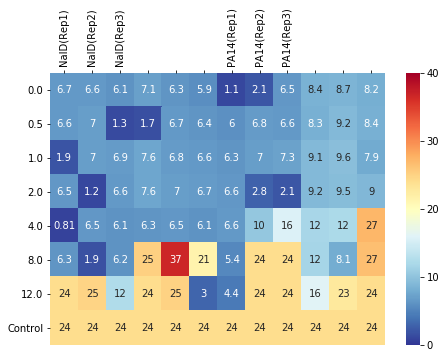

In [127]:
print('%2.2f <= lag time (h) <= %2.2f' %(np.min(output2['LagT'].values), np.max(output2['LagT'].values)))

fig,ax = plt.subplots(1,1,figsize=(7.5,5))
to_plot = pd.DataFrame(output2['LagT'].values.reshape(8,12,order='F'))
g = sns.heatmap(to_plot, robust=True, annot=True, cmap='RdYlBu_r', vmin=0, vmax=40, ax=ax, cbar=True)
ax.set_yticklabels(['0.0','0.5','1.0','2.0','4.0','8.0','12.0','Control'], rotation=0)
ax.set_xticklabels(['NalD(Rep1)','NalD(Rep2)','NalD(Rep3)','','','','PA14(Rep1)','PA14(Rep2)','PA14(Rep3)','','',''], rotation=90)
ax.xaxis.tick_top()
cbar = ax.collections[0].colorbar
cbar.set_ticks([0,10,20,30,40])
#cbar.set_ticklabels(['10', '20', '>=30'])